In [1]:
%matplotlib inline
from validphys.api import API
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate as scint
from collections import defaultdict, namedtuple
import operator
from pathlib import Path

from validphys.theorycovariance.construction import extract_target, compute_ratio_delta, compute_ht_parametrisation

In [2]:
fitname = "240816-01-7-02-sc"
thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]

In [3]:
H2_coeff_list = thcovmat_dict["H2_list"]
HL_coeff_list = thcovmat_dict["HL_list"]


# dict used to produce theory predictions to construct the theory covmat as well as to produce
# theory predictions from the fit performed using the ht covmat (i.e. the predicitons that should
# be compared to data)
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

In [4]:
# collect the information (predictions + kinematics) needed for the computation of the HT covmat

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)
preds_ht_cov_construction = API.group_result_central_table_no_table(**(S_dict | common_dict))
preds_ht = pd.DataFrame(preds_ht_cov_construction['theory_central'])

# collect the corresponding kinemacs
process_info = API.combine_by_type_ht(**(S_dict | common_dict))
N_full_data = np.sum([i for i in process_info.sizes.values()])
kinematics_DIS = np.concatenate([v for v in [process_info.data["DIS NC"], process_info.data["DIS CC"]]]).T
# TO CHECK: IS preds[][1] THE THEORY PREDICTION?
preds_DIS = np.concatenate([v for v in [process_info.preds["DIS NC"][1], process_info.preds["DIS CC"][1]]]).T
xvals_DIS = kinematics_DIS[0]
q2vals_DIS = kinematics_DIS[1]
yvals_DIS = kinematics_DIS[2]

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/210619-n3fit-001/210619-n3fit-001_0000.dat
210619-n3fit-001 PDF set, member #0, version 1
LHAPDF 6.5.4 loading all 101 PDFs in set 210619-n3fit-001
210619-n3fit-001, version 1; 101 PDF members


In [5]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

LHAPDF 6.5.4 loading all 501 PDFs in set 240816-01-7-02-sc
240816-01-7-02-sc, version 1; 501 PDF members


In [6]:
# compute the matrix X encoding the PDF uncertainties of the predictions
preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

X = np.zeros((preds.shape[0], preds.shape[0]))
for i in range(preds_onlyreplicas.shape[1]):
    X += np.outer(
        (preds_onlyreplicas[:, i] - mean_prediction), (preds_onlyreplicas[:, i] - mean_prediction)
    )
X *= 1 / preds_onlyreplicas.shape[1]

In [7]:
pd.options.mode.chained_assignment = None

data_by_process = API.groups_data_by_process(**(S_dict | common_dict))
PDF_thcovmat = API.pdf(**(S_dict | common_dict))

# ABMP parametrisationa
x_abmp = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
x_nodes = thcovmat_dict.get('ht_knots', x_abmp) 


included_proc = ["DIS NC"]
excluded_exp = {"DIS NC" : []}
included_exp = {}
for proc in included_proc:
    aux = []
    for exp in process_info.namelist[proc]:
        if exp not in excluded_exp[proc]:
            aux.append(exp)
    included_exp[proc] = aux

preds_ht.loc[['DIS NC', 'DIS CC'], 'x'] = xvals_DIS
preds_ht.loc[['DIS NC', 'DIS CC'], 'q2'] = q2vals_DIS
preds_ht.loc[['DIS NC', 'DIS CC'], 'y'] = yvals_DIS

# Initialise dataframe
for i in range(len(x_nodes)):
    preds_ht[f"p({i+1}+,0)"] = 0
    preds_ht[f"p(0,{i+1}+)"] = 0
    preds_ht[f"d({i+1}+,0)"] = 0
    preds_ht[f"d(0,{i+1}+)"] = 0

deltas = defaultdict(list)

for i_proc, proc in enumerate(process_info.namelist.keys()):
        for i_exp, exp in enumerate(process_info.namelist[proc]):
            dataset = data_by_process[i_proc].datasets[i_exp]
            kin_dict = {}

            if proc in included_proc and exp in included_exp[proc]:
                kin_dict['x']  = np.array(preds_ht.xs(exp, level=1, drop_level=False).loc[:,"x"])
                kin_dict['Q2'] = np.array(preds_ht.xs(exp, level=1, drop_level=False).loc[:,"q2"])
                kin_dict['y']  = np.array(preds_ht.xs(exp, level=1, drop_level=False).loc[:,"y"])
                kin_size =  kin_dict['x'].size
                target = extract_target(dataset)


                # Loop over the parameter
                for i in range(len(x_nodes)):
                    PC_2, PC_L = compute_ht_parametrisation(i, x_nodes, kin_dict, exp, H2_coeff_list, HL_coeff_list)
                    if target == 'proton':
                      deltas[f"p({i+1}+,0)"] += [PC_2]
                      deltas[f"p(0,{i+1}+)"] += [PC_L]
                      deltas[f"d({i+1}+,0)"] += [np.zeros(kin_size)]
                      deltas[f"d(0,{i+1}+)"] += [np.zeros(kin_size)]
                    elif target == 'deuteron':
                      deltas[f"p({i+1}+,0)"] += [np.zeros(kin_size)]
                      deltas[f"p(0,{i+1}+)"] += [np.zeros(kin_size)]
                      deltas[f"d({i+1}+,0)"] += [PC_2]
                      deltas[f"d(0,{i+1}+)"] += [PC_L]
                    elif target == 'ratio':
                      deltas[f"p({i+1}+,0)"] += [compute_ratio_delta(dataset, PDF_thcovmat, "p", PC_2) - compute_ratio_delta(dataset, PDF_thcovmat)]
                      deltas[f"p(0,{i+1}+)"] += [compute_ratio_delta(dataset, PDF_thcovmat, "p", PC_L) - compute_ratio_delta(dataset, PDF_thcovmat)]
                      deltas[f"d({i+1}+,0)"] += [compute_ratio_delta(dataset, PDF_thcovmat, "d", PC_2) - compute_ratio_delta(dataset, PDF_thcovmat)]
                      deltas[f"d(0,{i+1}+)"] += [compute_ratio_delta(dataset, PDF_thcovmat, "d", PC_L) - compute_ratio_delta(dataset, PDF_thcovmat)]
                    else:
                        raise ValueError("Could not detect target.")
            else:
                for i in range(len(x_nodes)):
                    deltas[f"p({i+1}+,0)"] += [np.zeros(preds_ht.xs(exp, level=1, drop_level=False).shape[0])]
                    deltas[f"p(0,{i+1}+)"] += [np.zeros(preds_ht.xs(exp, level=1, drop_level=False).shape[0])]
                    deltas[f"d({i+1}+,0)"] += [np.zeros(preds_ht.xs(exp, level=1, drop_level=False).shape[0])]
                    deltas[f"d(0,{i+1}+)"] += [np.zeros(preds_ht.xs(exp, level=1, drop_level=False).shape[0])]

delta_pred = []
for i in range(len(x_nodes)):
    temp_1 = np.array([])
    temp_2 = np.array([])
    temp_3 = np.array([])
    temp_4 = np.array([])
    for vec in zip(deltas[f"p({i+1}+,0)"], deltas[f"p(0,{i+1}+)"], deltas[f"d({i+1}+,0)"], deltas[f"d(0,{i+1}+)"]):
        temp_1 = np.concatenate((temp_1, vec[0]))
        temp_2 = np.concatenate((temp_2, vec[1]))
        temp_3 = np.concatenate((temp_3, vec[2]))
        temp_4 = np.concatenate((temp_4, vec[3]))
    
    preds_ht[f"p({i+1}+,0)"] = temp_1
    preds_ht[f"p(0,{i+1}+)"] = temp_2
    preds_ht[f"d({i+1}+,0)"] = temp_3
    preds_ht[f"d(0,{i+1}+)"] = temp_4
    delta_pred.append(preds_ht[f"p({i+1}+,0)"])
    delta_pred.append(preds_ht[f"p(0,{i+1}+)"])
    delta_pred.append(preds_ht[f"d({i+1}+,0)"])
    delta_pred.append(preds_ht[f"d(0,{i+1}+)"])

In [8]:
# Theory covariance matrix
S = np.zeros((delta_pred[0].size, delta_pred[0].size))
for delta in delta_pred:
    S += np.outer(delta, delta)

S = pd.DataFrame(S, index=delta_pred[0].index, columns=delta_pred[0].index)

# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

# Ensure that S anc C are ordered in the same way (in practice they already are)
S = S.reindex(C.index).T.reindex(C.index)

In [9]:
# Load the central value of the pseudodata
# this is needed to compute the distance between prediction and data
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

In [10]:
# Compute delta_T_tilde (Eq. 3.37) and P_tilde (Eq. 3.38) of arXiv:2105.05114

# The factors 1/sqrt(2) are to normalize for the fact that beta provides information about
# theoretical uncertainties along two directions
# CHECK THIS PART
# b_tilde SHOULD BE INDEPENDENT OF THE PRIOR THAT WE USE TO MODEL HT CORRECTIONS.
central_ht_coeffs = np.zeros(2*len(H2_coeff_list) + 2*len(HL_coeff_list)) 

# Construct beta tilde
H_single_list = np.concatenate((H2_coeff_list, HL_coeff_list, H2_coeff_list, HL_coeff_list))
beta_tilde = []
for i, par in enumerate(H_single_list):
  aux = np.zeros(H_single_list.size)
  aux[i] = par
  beta_tilde.append(aux)

S_tilde = np.zeros((len(beta_tilde[0]), len(beta_tilde[0])))
for tilde in beta_tilde:
    S_tilde += np.outer(tilde,tilde)

beta = delta_pred
S_hat = np.zeros((len(beta_tilde[0]),delta_pred[0].size))
for b in zip(beta_tilde, beta):
    S_hat += np.outer(b[0], b[1])

invcov = np.linalg.inv(C + S)

delta_T_tilde = -S_hat @ invcov @ (mean_prediction - dat_central)
# where are the X_tilde and X_hat terms in P_tilde?
# Maybe not present because we don't have correlations between theory parameters
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + (S_tilde - S_hat @ invcov @ S_hat.T)
posteriors = central_ht_coeffs + delta_T_tilde

In [11]:
class Prediction:
  def __init__(self, central, sigma):
    self.central = central
    self.sigma = sigma
    self.central_plus_sigma = central + sigma
    self.central_minus_sigma = central - sigma

  def __str__(self) -> str:
    return f"{self.central:.5f} ± {self.sigma:.3f}"

def map_target(i, list_length):
  if i < list_length/2:
    return "proton"
  else:
    return "deutron"
  
def map_type(i, list_length):
  if i%list_length/4 < list_length/4:
    return "H2"
  else:
    return "HL"


In [12]:
predictions_list = [Prediction(central, sigma) for central, sigma in zip(posteriors, np.sqrt(P_tilde.diagonal()))]
preds_dict = defaultdict(list)
preds_dict['proton'] = {"H2": predictions_list[0:len(H2_coeff_list)], 
                        "HL": predictions_list[len(H2_coeff_list):len(HL_coeff_list) + len(H2_coeff_list)]}
preds_dict['deuteron'] = {"H2": predictions_list[len(HL_coeff_list) + len(H2_coeff_list) : len(HL_coeff_list) + 2*len(H2_coeff_list)], 
                          "HL": predictions_list[len(HL_coeff_list) + 2*len(H2_coeff_list) : 2*len(HL_coeff_list) + 2*len(H2_coeff_list)]}

Print posteriors

In [13]:
label_string = ''
for i in range(len(x_nodes)):
  label_string += f"node {i+1:<15}"

print(f"{"HT name":<10}",label_string)
print(f"{"H2^p":>7} ", *[f"{preds_dict['proton']['H2'][i]}{"":<2}" for i in range(len(x_nodes))], end="\n\n")
print(f"{"HL^p":>7} ", *[f"{preds_dict['proton']['HL'][i]}{"":<2}" for i in range(len(x_nodes))], end="\n\n")
print(f"{"H2^d":>7} ", *[f"{preds_dict['deuteron']['H2'][i]}{"":<2}" for i in range(len(x_nodes))], end="\n\n")
print(f"{"HL^d":>7} ", *[f"{preds_dict['deuteron']['HL'][i]}{"":<2}" for i in range(len(x_nodes))])

print(f"\n X nodes: {x_nodes}")
df = pd.DataFrame(np.zeros((4, len(x_nodes))), columns=[f"node {i+1}" for i in range(len(x_nodes))])
df.index = ["H2^p","HL^p","H2^d","HL^d"]
for i in range(len(x_nodes)):
  array = [
    preds_dict['proton']['H2'][i].__str__(),
    preds_dict['proton']['HL'][i].__str__(),
    preds_dict['deuteron']['H2'][i].__str__(),
    preds_dict['deuteron']['HL'][i].__str__()
  ]
  df[f'node {i+1}'] = array

HT name    node 1              node 2              node 3              node 4              node 5              node 6              node 7              
   H2^p  -0.00261 ± 0.004   0.10586 ± 0.037   -0.02201 ± 0.028   0.00000 ± 0.200   -0.10924 ± 0.019   -0.09523 ± 0.149   0.00000 ± 0.000  

   HL^p  0.00000 ± 0.200   -0.01645 ± 0.019   -0.09915 ± 0.196   -0.01609 ± 0.022   0.00000 ± 0.200   -0.14336 ± 0.029   0.00000 ± 0.000  

   H2^d  -0.11475 ± 0.033   0.00000 ± 0.200   0.07085 ± 0.030   -0.01191 ± 0.200   -0.01768 ± 0.025   0.00000 ± 0.200   0.00000 ± 0.000  

   HL^d  0.00354 ± 0.200   0.05772 ± 0.074   0.00000 ± 0.200   0.00000 ± 0.200   0.00000 ± 0.200   0.00000 ± 0.200   0.00000 ± 0.000  

 X nodes: [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]


In [14]:
# check if the stored covmat is equal to S we recomputed above
fitpath = API.fit(fit=fitname).path
try:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_user_covmat.csv",
        sep="\t",
        encoding="utf-8",
        index_col=2,
        header=3,
        skip_blank_lines=False,
    )
except FileNotFoundError:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv",
        index_col=[0, 1, 2],
        header=[0, 1, 2],
        sep="\t|,",
        engine="python",
    ).fillna(0)
    storedcovmat_index = pd.MultiIndex.from_tuples(
        [(aa, bb, np.int64(cc)) for aa, bb, cc in stored_covmat.index],
        names=["group", "dataset", "id"],
    )
    stored_covmat = pd.DataFrame(
        stored_covmat.values, index=storedcovmat_index, columns=storedcovmat_index
    )
    stored_covmat = stored_covmat.reindex(S.index).T.reindex(S.index)


# Plots

In [15]:
class PlotHT:
  def __init__(self, preds, x_nodes, color, type, target, show_uncertainty = True):
    self.preds = preds
    self.color = color
    self.type = type
    self.target = target
    self.HT = sp.interpolate.CubicSpline(x_nodes, [pred.central for pred in self.preds])
    self.show_uncertainty = show_uncertainty
    if show_uncertainty:
      self.HT_plus = sp.interpolate.CubicSpline(x_nodes, [pred.central_plus_sigma for pred in self.preds])
      self.HT_minus = sp.interpolate.CubicSpline(x_nodes, [pred.central_minus_sigma for pred in self.preds])

  def plot_wrapper(self, ax):
    xv = np.logspace(-5, -0.0001, 100)
    legends = []
    legend_label = rf"$H^{self.target}_{self.type} \pm \sigma$"
    legend_name = [legend_label, "knots"]
    knots = ax.plot(x_nodes, [pred.central for pred in self.preds], 'o', label='data')
    pl = ax.plot(xv, self.HT(xv), ls = "-", lw = 1, color = self.color)

    pl_lg= ax.fill(np.NaN, np.NaN, color = self.color, alpha = 0.3) # Necessary for fancy legend
    legends.append((pl[0], pl_lg[0]))
    legends.append(knots[0])
    if self.show_uncertainty:
      ax.fill_between(xv, self.HT_plus(xv), self.HT_minus(xv), color = self.color, alpha = 0.3)
    ax.set_xscale("log")
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(rf"$H^{self.target}_{self.type}$", fontsize = 20)
    ax.set_title(rf"$H^{self.target}_{self.type}$", x = 0.15, y=0.85, fontsize=20)
    ax.legend(legends, legend_name, loc=[0.1,0.07], fontsize=10)

def make_dir(path):
  target_dir = Path(path)
  if not target_dir.is_dir():
      target_dir.mkdir(parents=True, exist_ok=True)

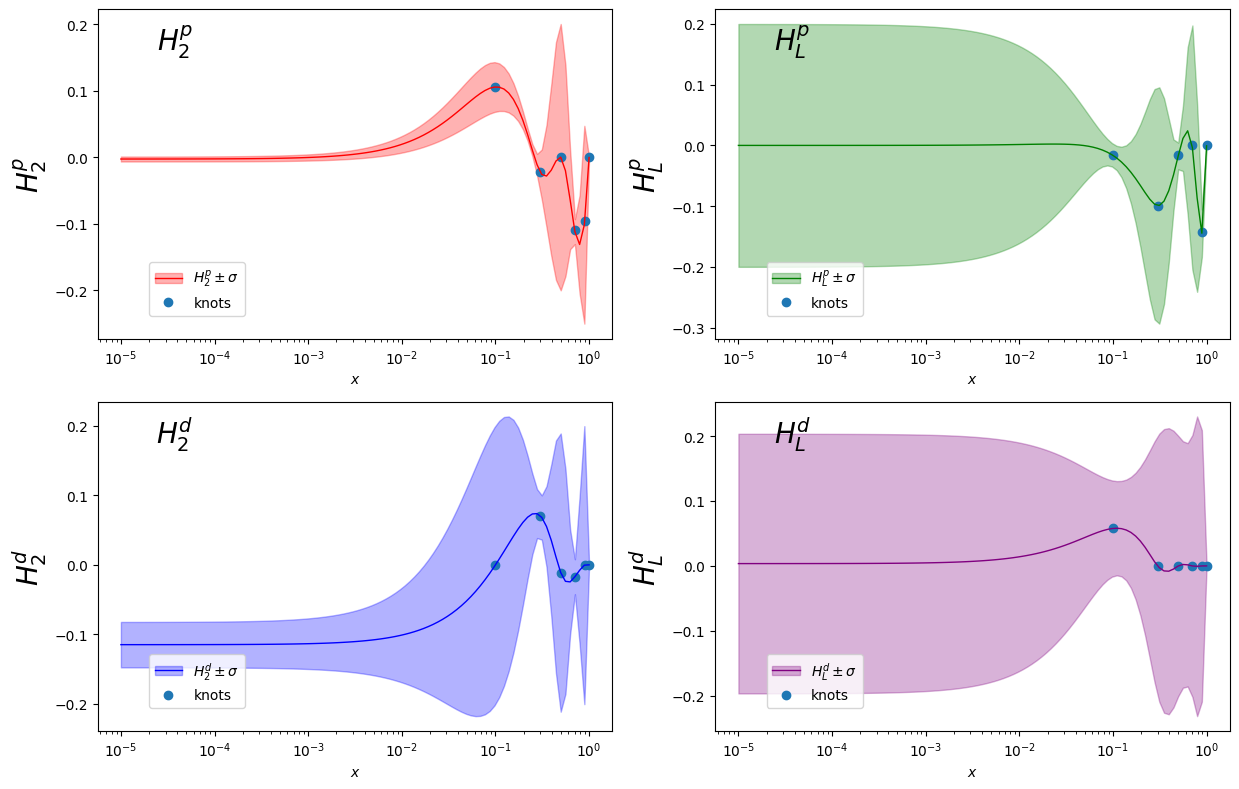

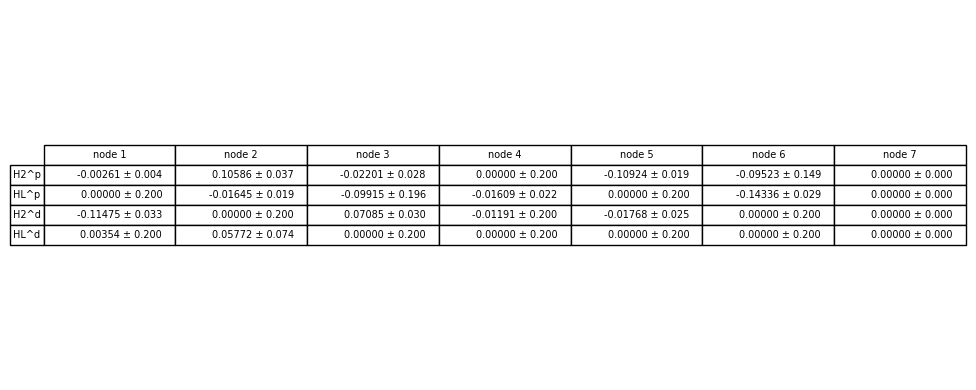

In [16]:
proton_H2 = PlotHT(preds_dict['proton']['H2'], x_nodes, 'red', "2", 'p')
proton_HL = PlotHT(preds_dict['proton']['HL'], x_nodes, 'green', "L", 'p')
deuteron_H2 = PlotHT(preds_dict['deuteron']['H2'], x_nodes, 'blue', "2", 'd')
deuteron_HL = PlotHT(preds_dict['deuteron']['HL'], x_nodes, 'purple', "L", 'd')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12.5, 8))

proton_H2.plot_wrapper(axs[0][0])
proton_HL.plot_wrapper(axs[0][1])
deuteron_H2.plot_wrapper(axs[1][0])
deuteron_HL.plot_wrapper(axs[1][1])


# Plot the table
fig_posterior, ax_posterior = plt.subplots(figsize=(10, 4))  # Set the figure size
ax_posterior.axis('tight')
ax_posterior.axis('off')  # Turn off the axis

# Create a table plot from the DataFrame
table = ax_posterior.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')


save_dir = f"./figs/{fitname}"
make_dir(save_dir)
fig.tight_layout()
fig_posterior.tight_layout()
fig.savefig(save_dir + "/plot.pdf")
fig_posterior.savefig(save_dir + "/table.pdf")

# Tests for the posterior

In [17]:
raise Exception("I stop here")

Exception: I stop here

In [ ]:
class PlotHT_MC:
  def __init__(self, preds, x_nodes, color, type, target):
    self.preds = preds
    self.color = color
    self.type = type
    self.target = target
    self.replicas = 100
    self.preds_rep = np.full(shape=(self.replicas, len(preds)), fill_value=np.zeros(len(preds)) )
    self.HT_rep = []
    sigma = np.array([pred.sigma for pred in self.preds])
    central = np.array([pred.central for pred in self.preds])
    rng = np.random.default_rng(1)
    for rep in range(0, self.replicas):
      k = rng.standard_normal(central.size)
      fluctuated_preds = central + np.multiply(k,sigma)
      self.preds_rep[rep] = fluctuated_preds
      self.HT_rep.append(sp.interpolate.CubicSpline(x_nodes, fluctuated_preds))

    xv = np.linspace(1e-5, x_nodes[-1], 1000)
    mean = np.zeros_like(xv)
    std = np.zeros_like(xv)

    for rep in range(0, self.replicas):
      Y = self.HT_rep[rep](xv)
      mean += Y
      std = std + np.power(Y,2)

    mean = np.divide(mean, self.replicas)
    std = np.divide(std,self.replicas-1)
    std = std - np.power(mean,2)

    self.mean = mean
    self.std = std
    self.xv= xv


  def plot_wrapper(self, save=False):
    legends = []
    legend_label = rf"$H^{self.target}_{self.type} \pm \sigma$"
    legend_name = [legend_label, "knots"]
    fig, ax = plt.subplots(figsize=(12.5, 8))
    knots = ax.plot(x_nodes, [pred.central for pred in self.preds], 'o', label='data')
    pl = ax.plot(self.xv, self.mean, ls = "-", lw = 1, color = self.color)

    pl_lg= ax.fill(np.NaN, np.NaN, color = self.color, alpha = 0.3) # Necessary for fancy legend
    legends.append((pl[0], pl_lg[0]))
    legends.append(knots[0])
    ax.fill_between(self.xv, self.mean + self.std, self.mean - self.std, color = self.color, alpha = 0.3)
    ax.set_xscale("log")
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(rf"$H^{self.target}_{self.type}$", fontsize = 20)
    ax.set_title(rf"$H^{self.target}_{self.type}$", x = 0.15, y=0.85, fontsize=30)
    fig.legend(legends, legend_name, loc=[0.1,0.15], fontsize=15)

    if save:
      save_dir = f"./figs/{fitname}"
      self.make_dir(save_dir)
      plt.savefig(save_dir + "/" + f"MC_H_{self.type}_{self.target}.pdf")
      
    plt.show()

  def make_dir(self, path):
    target_dir = Path(path)
    if not target_dir.is_dir():
        target_dir.mkdir(parents=True, exist_ok=True)


proton_H2 = PlotHT_MC(preds_dict['proton']['H2'], x_nodes, 'red', "2", 'p')
proton_HL = PlotHT_MC(preds_dict['proton']['HL'], x_nodes, 'green', "L", 'p')
deuteron_H2 = PlotHT_MC(preds_dict['deuteron']['H2'], x_nodes, 'blue', "2", 'd')
deuteron_HL = PlotHT_MC(preds_dict['deuteron']['HL'], x_nodes, 'purple', "L", 'd')

proton_H2.plot_wrapper(save=False)
proton_HL.plot_wrapper(save=False)
deuteron_H2.plot_wrapper(save=False)
deuteron_HL.plot_wrapper(save=False)

In [ ]:
class PlotHT_intervals:
  def __init__(self, preds, x_nodes, color, type, target):
    self.preds = preds
    self.color = color
    self.type = type
    self.target = target
    self.x_nodes = x_nodes
    self.x_intervals = self.construct_intervals()
    self.interpolation_by_interval = self.construct_interpolation_by_interval()
    self.colour_by_interval = self.construct_colors_by_interval()
    self.colors = ["red", "blue", "green", "black", "orange", "purple"]#self.construct_colors_by_interval()
    self.buffer_color = (0,0,0)


  def construct_intervals(self):
    return [self.x_nodes[k:k+2] for k in range(len(self.x_nodes)-1)]
  
  def construct_colors_by_interval(self):
    random_rgbs = [np.random.uniform(0, 1, 3) for _ in range(len(self.x_intervals))]
    return [(rgb[0],rgb[1],rgb[2]) for rgb in random_rgbs]

  def construct_interpolation_by_interval(self):
    int_functions_by_intervals = []
    pred_array = [pred.central for pred in self.preds]
    for k, interval in enumerate(self.x_intervals):
      func = sp.interpolate.CubicSpline(interval, pred_array[k:k+2])
      int_functions_by_intervals.append(func)

    #xv = np.logspace(-5, -0.001, 100)
    #fig, ax = plt.subplots(figsize=(12.5, 8))
    #for k, f in enumerate(int_functions_by_intervals):
    #  if k !=0:
    #    ax.plot(xv, f(xv), ls = "-", lw = 1, label=f"interval {k}")
    #ax.legend()
    #ax.set_xscale("log")

    #fig2, ax2 = plt.subplots(figsize=(12.5, 8))
    #ax2.plot(xv, int_functions_by_intervals[1](xv), ls = "-", lw = 1, label=f"interval {k}")
    #ax2.legend()
    #ax2.set_xscale("log")

    return int_functions_by_intervals 
  
  def interpolation_func(self, x):
    # This part can be improved with interval tree
    for k, interval in enumerate(self.x_intervals):
      error_flag = True
      if x >= interval[0] and x < interval[1]:
        error_flag = False
        return self.interpolation_by_interval[k](x)
      
    if error_flag:
      raise RuntimeError(f"{x} does not belong to any of the intervals.")
      

  def plot_wrapper(self, save=False):
    xv = np.logspace(-5, -0.0001, 100)
    #xv = np.linspace(0.001,0.1, 10)
    legends = []
    legend_label = rf"$H^{self.target}_{self.type} \pm \sigma$"
    legend_name = [legend_label, "knots"]
    fig, ax = plt.subplots(figsize=(12.5, 8))
    knots = ax.plot(x_nodes, [pred.central for pred in self.preds], 'o', label='data')

    pl = ax.plot(xv, [self.interpolation_func(x) for x in xv], ls = "-", lw = 1, color = self.buffer_color)

    #pl_lg= ax.fill(np.NaN, np.NaN, color = self.color, alpha = 0.3) # Necessary for fancy legend
    #legends.append((pl[0], pl_lg[0]))
    legends.append(knots[0])
    #ax.fill_between(xv, self.HT_plus(xv), self.HT_minus(xv), color = self.color, alpha = 0.3)
    ax.set_xscale("log")
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(rf"$H^{self.target}_{self.type}$", fontsize = 20)
    ax.set_title(rf"$H^{self.target}_{self.type}$", x = 0.15, y=0.85, fontsize=30)
    fig.legend(legends, legend_name, loc=[0.1,0.15], fontsize=15)

    if save:
      save_dir = f"./figs/{fitname}"
      self.make_dir(save_dir)
      plt.savefig(save_dir + "/" + f"H_{self.type}_{self.target}.pdf")
      
    plt.show()

  def make_dir(self, path):
    target_dir = Path(path)
    if not target_dir.is_dir():
        target_dir.mkdir(parents=True, exist_ok=True)

proton_H2 = PlotHT_intervals(preds_dict['proton']['H2'], x_nodes, 'red', "2", 'p')
proton_HL = PlotHT_intervals(preds_dict['proton']['HL'], x_nodes, 'green', "L", 'p')
deuteron_H2 = PlotHT_intervals(preds_dict['deuteron']['H2'], x_nodes, 'blue', "2", 'd')
deuteron_HL = PlotHT_intervals(preds_dict['deuteron']['HL'], x_nodes, 'purple', "L", 'd')

proton_H2.plot_wrapper(save=False)
proton_HL.plot_wrapper(save=True)
deuteron_H2.plot_wrapper(save=True)
deuteron_HL.plot_wrapper(save=True)

In [60]:
x_nodes_test = proton_H2.x_nodes
predictions_test = [0.1 for pred in proton_H2.preds]#[pred.central for pred in proton_H2.preds]

In [61]:
def x_nodes_prior_and_preds(k):
  nodes_prior = np.zeros_like(x_nodes_test)
  nodes_prior[k] = x_nodes_test[k]
  pred_prior = np.zeros_like(x_nodes_test)
  pred_prior[k] = predictions_test[k]
  return nodes_prior, pred_prior

In [ ]:
xv = np.logspace(-5, -0.0001, 100)
fig, ax = plt.subplots(figsize=(12.5, 8))

for k in range(len(x_nodes_test)):
  node, pre = x_nodes_prior_and_preds(k)
  CStest = sp.interpolate.CubicSpline(x_nodes_test, pre)
  pl = ax.plot(xv, CStest(xv), ls = "-", lw = 1, label=f'shift knot {k}')
  knots = ax.plot(node[k], pre[k], 'o', label='data', color=pl[0].get_color())

ax.legend()
ax.set_xscale("log")


In [ ]:
class PlotHT_interp1d(PlotHT):
  def __init__(self, preds, x_nodes, color, type, target):
    super().__init__(preds, x_nodes, color, type, target, False)
    self.HT = sp.interpolate.interp1d(x_nodes, [pred.central for pred in self.preds], bounds_error = False, kind = 'cubic')
    self.HT_plus = sp.interpolate.CubicSpline(x_nodes, [pred.central_plus_sigma for pred in self.preds])
    self.HT_minus = sp.interpolate.CubicSpline(x_nodes, [pred.central_minus_sigma for pred in self.preds])

test = PlotHT_interp1d(preds_dict['proton']['H2'], x_nodes, 'red', "2", 'p')
test.plot_wrapper(save=False)

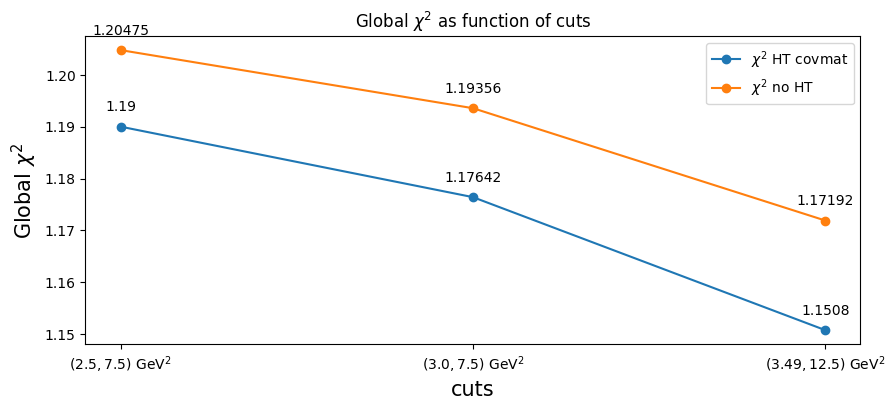

In [29]:
chi2_ht = [1.19000,	1.17642,	1.15080]
chi2_no_ht = [1.20475, 1.19356, 1.17192]
cuts = [
  r"$(2.5, 7.5)$ GeV$^2$",
  r"$(3.0, 7.5)$ GeV$^2$",
  r"$(3.49, 12.5)$ GeV$^2$"
  ]

fig_tmp, ax_tmp = plt.subplots(figsize=(10, 4))
ax_tmp.plot(cuts, chi2_ht, 'o-', label=r"$\chi^2$ HT covmat")
ax_tmp.plot(cuts, chi2_no_ht, 'o-', label=r"$\chi^2$ no HT")
ax_tmp.set_ylabel(r'Global $\chi^2$', fontsize=15)
ax_tmp.set_xlabel(r'cuts', fontsize=15)
ax_tmp.set_title(r'Global $\chi^2$ as function of cuts')

for i, value in enumerate(zip(chi2_ht, chi2_no_ht)):
    ax_tmp.text(i, value[0] + 0.003, str(value[0]), ha='center')
    ax_tmp.text(i, value[1] + 0.003, str(value[1]), ha='center')

ax_tmp.legend()

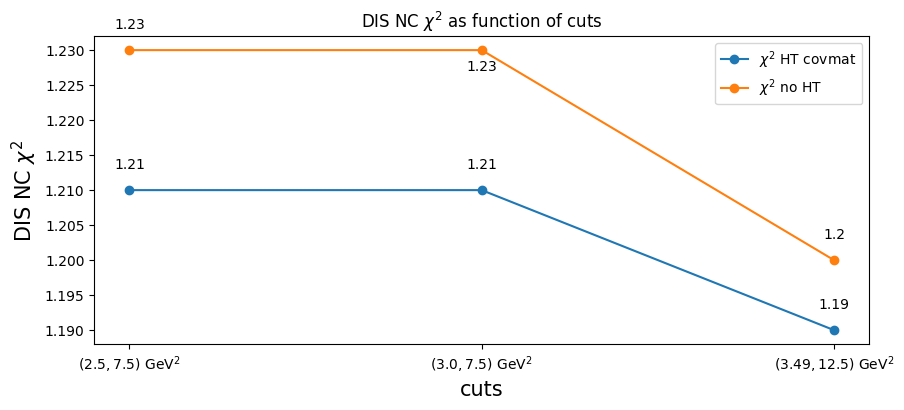

In [31]:
chi2_ht_DIS_NC = [1.21,	1.21,	1.19]
chi2_no_ht_DIS_NC = [1.23, 1.23, 1.20]
cuts_DIS_NC = [
  r"$(2.5, 7.5)$ GeV$^2$",
  r"$(3.0, 7.5)$ GeV$^2$",
  r"$(3.49, 12.5)$ GeV$^2$"
  ]

fig_tmp_DIS_NC, ax_tmp_DIS_NC = plt.subplots(figsize=(10, 4))
ax_tmp_DIS_NC.plot(cuts_DIS_NC, chi2_ht_DIS_NC, 'o-', label=r"$\chi^2$ HT covmat")
ax_tmp_DIS_NC.plot(cuts_DIS_NC, chi2_no_ht_DIS_NC, 'o-', label=r"$\chi^2$ no HT")
ax_tmp_DIS_NC.set_ylabel(r'DIS NC $\chi^2$', fontsize=15)
ax_tmp_DIS_NC.set_xlabel(r'cuts', fontsize=15)
ax_tmp_DIS_NC.set_title(r'DIS NC $\chi^2$ as function of cuts')

for i, value in enumerate(zip(chi2_ht_DIS_NC, chi2_no_ht_DIS_NC)):
    ax_tmp_DIS_NC.text(i, value[0] + 0.003, str(value[0]), ha='center')
    ax_tmp_DIS_NC.text(i, 
                       value[1] - 0.003 if i == 1 else value[1] + 0.003, 
                       str(value[1]), ha='center')

ax_tmp_DIS_NC.legend()